In [1]:
import os
import json
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# GPU설정
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
        # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)

# 6-1. 프로젝트: CutMix 또는 Mixup 비교실험 하기
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?

In [3]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


## 1. Augmentation을 적용한 데이터셋 만들기
---
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

**Q. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?**

A.  
CutMix는 두 이미지와 라벨을 혼합하여 새로운 이미지와 라벨을 생성하는 데이터 증강 기법입니다. 이 기법은 단일 이미지가 아닌 이미지 배치에 적용되어야 합니다. CutMix를 사용할 때, 배치에서 무작위로 선택된 이미지의 일부를 현재 이미지에 삽입합니다. 이러한 조작은 여러 이미지가 혼합될 수 있는 배치에서 수행되어야 하므로, CutMix는 `batch()` 함수 이후에 적용되어야 합니다.

- CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [5]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


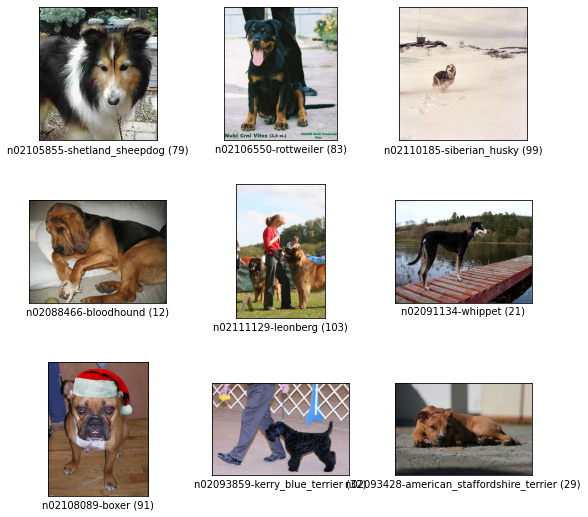

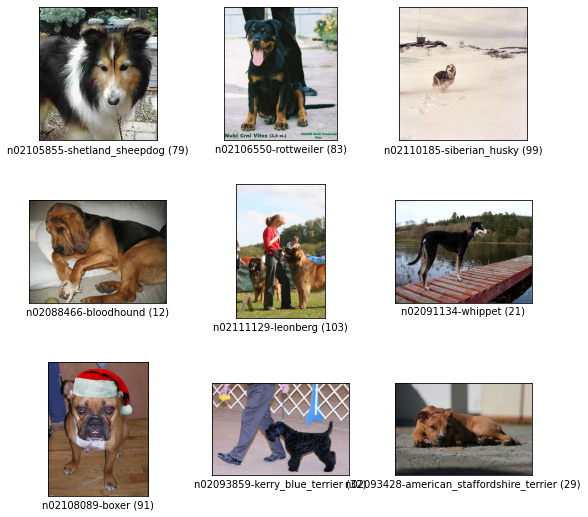

In [8]:
tfds.show_examples(ds_train, ds_info)

In [7]:
# 데이터셋 준비
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

## 2. 모델 만들기
---
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [10]:
resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


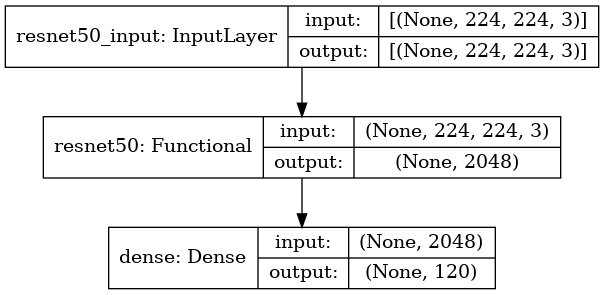

In [11]:
from tensorflow.keras import utils
utils.plot_model(resnet50, show_shapes = True)

- Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어줍니다.

In [12]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [13]:
aug_resnet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


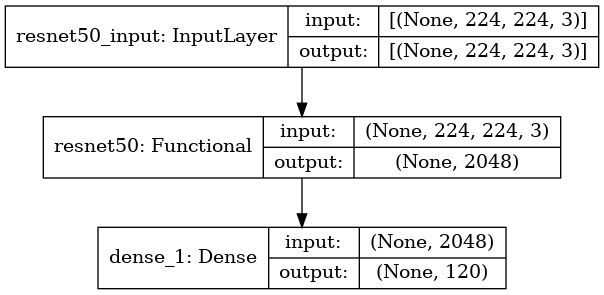

In [14]:
utils.plot_model(aug_resnet50, show_shapes = True)

- 텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.

In [15]:
# 데이터셋 Augmentation 적용 여부에 따라 나누기
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


In [16]:
# Checkpoint를 저장할 경로 설정
checkpoint_path_resnet50 = "resnet50/cp.ckpt"
checkpoint_path_aug_resnet50 = "aug_resnet50/cp.ckpt"

In [17]:
# 모델의 가중치를 저장하는 콜백 생성
cp_callback_resnet50 = ModelCheckpoint(filepath=checkpoint_path_resnet50,
                                       save_weights_only=True,
                                       verbose=1)

cp_callback_aug_resnet50 = ModelCheckpoint(filepath=checkpoint_path_aug_resnet50,
                                           save_weights_only=True,
                                           verbose=1)

## 3. 모델 훈련하기
---
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

**Q. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?**
A.  
- `sparse_categorical_crossentropy`를 사용하지 못하는 이유는 CutMix와 같은 데이터 증강 기법을 사용할 때 라벨이 단일 클래스가 아닌 혼합된 형태로 표현되기 때문입니다. 일반적으로 `sparse_categorical_crossentropy`는 각 샘플에 대해 단일 정수로 된 클래스 라벨을 사용하지만, CutMix를 사용하면 각 이미지의 라벨이 두 클래스의 비율로 혼합된 형태로 나타납니다. 예를 들어, 이미지의 일부가 클래스 A이고 다른 부분이 클래스 B일 경우, 이 혼합된 라벨은 단일 정수가 아니라 두 클래스에 대한 비율 정보를 담은 벡터 형태가 됩니다. 따라서 이러한 혼합 라벨을 처리하기 위해서는 `categorical_crossentropy`와 같은 손실 함수를 사용해야 합니다.

- 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

In [22]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 10

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback_resnet50]
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
750/750 [==============================] - 165s 205ms/step - loss: 2.1956 - accuracy: 0.4478 - val_loss: 3.8407 - val_accuracy: 0.1474

Epoch 00001: saving model to resnet50/cp.ckpt
Epoch 2/10
750/750 [==============================] - 153s 205ms/step - loss: 0.7499 - accuracy: 0.7933 - val_loss: 1.1516 - val_accuracy: 0.6691

Epoch 00002: saving model to resnet50/cp.ckpt
Epoch 3/10
750/750 [==============================] - 153s 204ms/step - loss: 0.2406 - accuracy: 0.9477 - val_loss: 0.9188 - val_accuracy: 0.7280

Epoch 00003: saving model to resnet50/cp.ckpt
Epoch 4/10
750/750 [==============================] - 153s 205ms/step - loss: 0.0691 - accuracy: 0.9927 - val_loss: 0.8931 - val_accuracy: 0.7392

Epoch 00004: saving model to resnet50/cp.ckpt
Epoch 5/10
750/750 [==============================] - 153s 204ms/step - loss: 0.0289 - accuracy: 0.9986 - val_loss: 0.9104 - val_accuracy: 0.7359

Epoch 00005: saving model to resnet50/cp.ckpt
Epoch 6/10
750/750 [===============

In [23]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback_aug_resnet50]
)


Epoch 1/10
750/750 [==============================] - 161s 205ms/step - loss: 2.2754 - accuracy: 0.4271 - val_loss: 3.0976 - val_accuracy: 0.2464

Epoch 00001: saving model to aug_resnet50/cp.ckpt
Epoch 2/10
750/750 [==============================] - 153s 204ms/step - loss: 0.9219 - accuracy: 0.7381 - val_loss: 1.3022 - val_accuracy: 0.6339

Epoch 00002: saving model to aug_resnet50/cp.ckpt
Epoch 3/10
750/750 [==============================] - 153s 204ms/step - loss: 0.5000 - accuracy: 0.8639 - val_loss: 1.2638 - val_accuracy: 0.6435

Epoch 00003: saving model to aug_resnet50/cp.ckpt
Epoch 4/10
750/750 [==============================] - 153s 204ms/step - loss: 0.2621 - accuracy: 0.9387 - val_loss: 1.0438 - val_accuracy: 0.7021

Epoch 00004: saving model to aug_resnet50/cp.ckpt
Epoch 5/10
750/750 [==============================] - 153s 204ms/step - loss: 0.1473 - accuracy: 0.9716 - val_loss: 1.0868 - val_accuracy: 0.6936

Epoch 00005: saving model to aug_resnet50/cp.ckpt
Epoch 6/10
750/

In [24]:
# 학습 히스토리 저장
history_dict_resnet50 = history_resnet50_no_aug.history
json.dump(history_dict_resnet50, open("history_resnet50_no_aug.json", 'w'))

history_dict_aug_resnet50 = history_aug_resnet50.history
json.dump(history_dict_aug_resnet50, open("history_aug_resnet50.json", 'w'))

## 4. 훈련 과정 시각화하기
---
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

훈련 과정을 시각화 해봅시다.

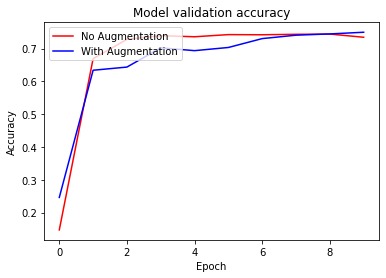

In [25]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

조금 더 확대해 살펴봅시다.

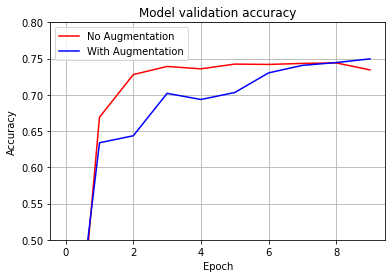

In [26]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

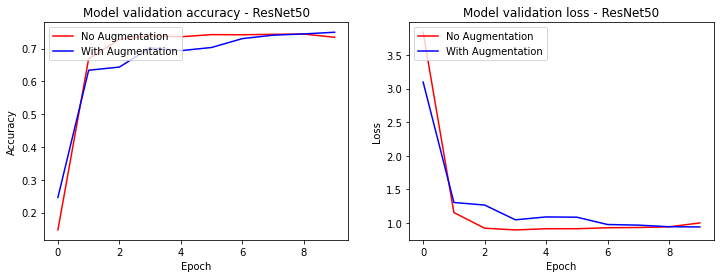

In [27]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_aug_resnet50.history['val_loss'], 'b')
plt.title('Model validation loss - ResNet50')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')

plt.show()

## 추가 학습 후 모델 시각화

In [18]:
# 추가 학습시 Checkpoint를 저장할 경로 설정
checkpoint_path_resnet50 = "resnet50/cp.ckpt"
checkpoint_path_aug_resnet50 = "aug_resnet50/cp.ckpt"

In [19]:
# 저장된 모델 가중치 불러오기
resnet50.load_weights(checkpoint_path_resnet50)
aug_resnet50.load_weights(checkpoint_path_aug_resnet50)

# 저장된 학습 히스토리 불러오기
history_dict_resnet50 = json.load(open("history_resnet50_no_aug.json", 'r'))
history_dict_aug_resnet50 = json.load(open("history_aug_resnet50.json", 'r'))

In [20]:
# 추가 학습을 위한 콜백 설정
cp_callback_resnet50 = ModelCheckpoint(
    filepath=checkpoint_path_resnet50, save_weights_only=True, verbose=1)

cp_callback_aug_resnet50 = ModelCheckpoint(
    filepath=checkpoint_path_aug_resnet50, save_weights_only=True, verbose=1)


In [60]:
# 추가 학습을 위한 에포크 설정
additional_epochs = 10

# ResNet50 모델 추가 컴파일 및 학습
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

additional_history_resnet50 = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=additional_epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback_resnet50]
)

Epoch 1/10
750/750 [==============================] - 163s 207ms/step - loss: 0.0055 - accuracy: 0.9996 - val_loss: 1.0456 - val_accuracy: 0.7339

Epoch 00001: saving model to resnet50/cp.ckpt
Epoch 2/10
750/750 [==============================] - 155s 206ms/step - loss: 0.0046 - accuracy: 0.9997 - val_loss: 1.0337 - val_accuracy: 0.7373

Epoch 00002: saving model to resnet50/cp.ckpt
Epoch 3/10
750/750 [==============================] - 153s 204ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 1.0413 - val_accuracy: 0.7364

Epoch 00003: saving model to resnet50/cp.ckpt
Epoch 4/10
750/750 [==============================] - 155s 206ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 1.0478 - val_accuracy: 0.7376

Epoch 00004: saving model to resnet50/cp.ckpt
Epoch 5/10
750/750 [==============================] - 153s 204ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 1.0496 - val_accuracy: 0.7367

Epoch 00005: saving model to resnet50/cp.ckpt
Epoch 6/10
750/750 [===============

In [61]:
# Augmented ResNet50 모델 추가 컴파일 및 학습
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

additional_history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=additional_epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback_aug_resnet50]
)

Epoch 1/10
750/750 [==============================] - 163s 206ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.0451 - val_accuracy: 0.7488

Epoch 00001: saving model to aug_resnet50/cp.ckpt
Epoch 2/10
750/750 [==============================] - 153s 204ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 1.0172 - val_accuracy: 0.7543

Epoch 00002: saving model to aug_resnet50/cp.ckpt
Epoch 3/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 1.0126 - val_accuracy: 0.7558

Epoch 00003: saving model to aug_resnet50/cp.ckpt
Epoch 4/10
750/750 [==============================] - 153s 204ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.0290 - val_accuracy: 0.7536

Epoch 00004: saving model to aug_resnet50/cp.ckpt
Epoch 5/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 1.0301 - val_accuracy: 0.7541

Epoch 00005: saving model to aug_resnet50/cp.ckpt
Epoch 6/10
750/

In [62]:
# 추가 학습 히스토리를 기존 히스토리에 추가
for key in history_dict_resnet50.keys():
    history_dict_resnet50[key].extend(additional_history_resnet50.history[key])
for key in history_dict_aug_resnet50.keys():
    history_dict_aug_resnet50[key].extend(additional_history_aug_resnet50.history[key])

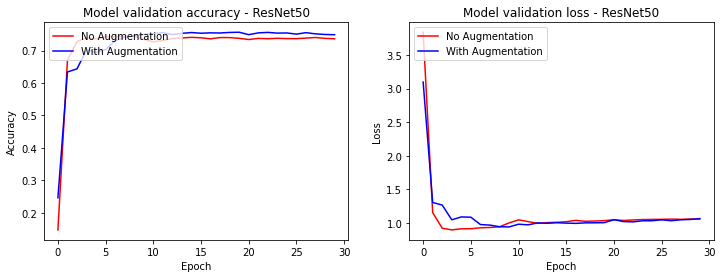

In [63]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dict_resnet50['val_accuracy'], 'r')
plt.plot(history_dict_aug_resnet50['val_accuracy'], 'b')
plt.title('Model validation accuracy - ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_dict_resnet50['val_loss'], 'r')
plt.plot(history_dict_aug_resnet50['val_loss'], 'b')
plt.title('Model validation loss - ResNet50')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')

plt.show()

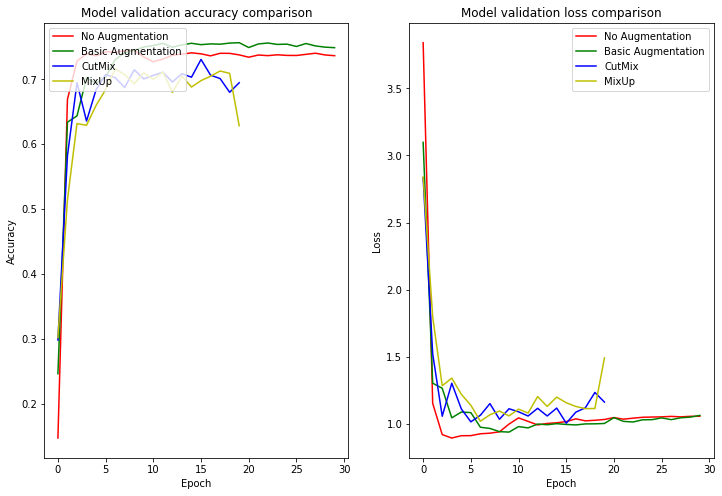

In [64]:
# 결과 시각화 (아래 단계 수행 후 추가 학습 시 4가지 방법 비교) 
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history_dict_resnet50['val_accuracy'], 'r')
plt.plot(history_dict_aug_resnet50['val_accuracy'], 'g')
plt.plot( history_dict_cutmix['val_accuracy'], 'b')
plt.plot(history_dict_mixup['val_accuracy'], 'y')
plt.title('Model validation accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_dict_resnet50['val_loss'], 'r')
plt.plot(history_dict_aug_resnet50['val_loss'], 'g')
plt.plot( history_dict_cutmix['val_loss'], 'b')
plt.plot(history_dict_mixup['val_loss'], 'y')
plt.title('Model validation loss comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper right')
plt.show()

In [65]:
# 학습 히스토리 저장
json.dump(history_dict_resnet50, open("history_resnet50_no_aug.json", 'w'))

json.dump(history_dict_aug_resnet50, open("history_aug_resnet50.json", 'w'))

## 5. Augmentation에 의한 모델 성능 비교
---
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [21]:
# cutmix
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=0.5, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        if tf.random.uniform([]) < prob:
            image_a = image[i]
            label_a = label[i]
            j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
            image_b = image[j]
            label_b = label[j]
            x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
            mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
            mixed_label = mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes)
        else:
            # CutMix 미적용
            mixed_img = image[i]
            mixed_label = label[i]
            if len(mixed_label.shape) == 0:
                mixed_label = tf.one_hot(mixed_label, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [22]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

def mixup(image, label, prob=0.5, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        if tf.random.uniform([]) < prob:
            image_a = image[i]
            label_a = label[i]
            j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
            image_b = image[j]
            label_b = label[j]
            mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)

        else:
            # CutMix 미적용
            mixed_img = image[i]
            mixed_label = label[i]
            if len(mixed_label.shape) == 0:
                mixed_label = tf.one_hot(mixed_label, num_classes)

        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [23]:
# 모델 저장을 위한 체크포인트 경로 설정
checkpoint_path_cutmix = "cutmix_resnet50/cp.ckpt"
checkpoint_path_mixup = "mixup_resnet50/cp.ckpt"

In [24]:
# 체크포인트 콜백 생성
cp_callback_cutmix = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_cutmix, 
    save_weights_only=True, 
    verbose=1)

cp_callback_mixup = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_mixup, 
    save_weights_only=True, 
    verbose=1)

In [25]:
# 데이터셋(Dataset) 준비
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):

    ds = ds.map(
      normalize_and_resize_img,
      num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment)
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
          cutmix,
          num_parallel_calls=2
      )
    elif not is_test and with_mixup:
        ds = ds.map(
          mixup,
          num_parallel_calls=2
      )
    else:
        ds = ds.map(
          onehot,
          num_parallel_calls=2
      )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [26]:
# CutMix와 MixUp 적용을 위한 데이터셋 준비
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)


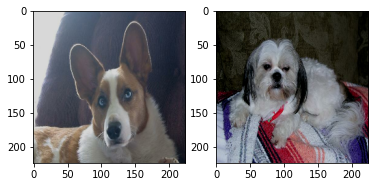

In [27]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_cutmix.take(1)):
    if i == 0:
        image_a = image[2]
        image_b = image[3]
        label_a = label[2]
        label_b = label[3]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [28]:
# 새로운 모델 생성 (CutMix 적용 모델)
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [29]:
# 새로운 모델 생성 (MixUp 적용 모델)
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])


- **커널이 죽어서 부득이하게 batch_size를 줄였다가 에러가 생겨서 에폭을 낮추고 모델을 여러번 학습시키기로 하였습니다.**

In [27]:
# 새로운 모델 컴파일 및 훈련 (CutMix 적용 모델)
EPOCH = 5
batch_size = 16 

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback_cutmix]
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/5
750/750 [==============================] - 168s 206ms/step - loss: 3.1160 - accuracy: 0.3086 - val_loss: 2.8326 - val_accuracy: 0.2984

Epoch 00001: saving model to cutmix_resnet50/cp.ckpt
Epoch 2/5
750/750 [==============================] - 154s 206ms/step - loss: 2.0492 - accuracy: 0.5652 - val_loss: 1.5207 - val_accuracy: 0.5823

Epoch 00002: saving model to cutmix_resnet50/cp.ckpt
Epoch 3/5
750/750 [==============================] - 154s 206ms/step - loss: 1.7279 - accuracy: 0.6629 - val_loss: 1.0558 - val_accuracy: 0.6946

Epoch 00003: saving model to cutmix_resnet50/cp.ckpt
Epoch 4/5
750/750 [==============================] - 154s 206ms/step - loss: 1.5024 - accuracy: 0.7330 - val_loss: 1.3019 - val_accuracy: 0.6356

Epoch 00004: saving model to cutmix_resnet50/cp.ckpt
Epoch 5/5
750/750 [==============================] - 154s 205ms/step - loss: 1.3816 - accuracy: 0.7747 - val_loss: 1.1105 - val_accuracy: 0.6839

Epoch 00005: saving model to cutmix_resnet50/cp.ckpt


In [28]:
# 새로운 모델 컴파일 및 훈련 (MixUp 적용 모델)
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[cp_callback_mixup]
)

Epoch 1/5
750/750 [==============================] - 163s 207ms/step - loss: 3.1211 - accuracy: 0.3101 - val_loss: 2.8392 - val_accuracy: 0.3022

Epoch 00001: saving model to mixup_resnet50/cp.ckpt
Epoch 2/5
750/750 [==============================] - 155s 206ms/step - loss: 2.0529 - accuracy: 0.5672 - val_loss: 1.7962 - val_accuracy: 0.5146

Epoch 00002: saving model to mixup_resnet50/cp.ckpt
Epoch 3/5
750/750 [==============================] - 154s 206ms/step - loss: 1.7383 - accuracy: 0.6717 - val_loss: 1.2827 - val_accuracy: 0.6316

Epoch 00003: saving model to mixup_resnet50/cp.ckpt
Epoch 4/5
750/750 [==============================] - 154s 206ms/step - loss: 1.5148 - accuracy: 0.7422 - val_loss: 1.3398 - val_accuracy: 0.6291

Epoch 00004: saving model to mixup_resnet50/cp.ckpt
Epoch 5/5
750/750 [==============================] - 154s 206ms/step - loss: 1.3759 - accuracy: 0.7986 - val_loss: 1.2194 - val_accuracy: 0.6597

Epoch 00005: saving model to mixup_resnet50/cp.ckpt


In [29]:
# 학습 히스토리 저장
history_dict_cutmix = history_cutmix_resnet50.history
json.dump(history_dict_cutmix, open("cutmix_resnet50_history.json", 'w'))

history_dict_mixup = history_mixup_resnet50.history
json.dump(history_dict_mixup, open("mixup_resnet50_history.json", 'w'))

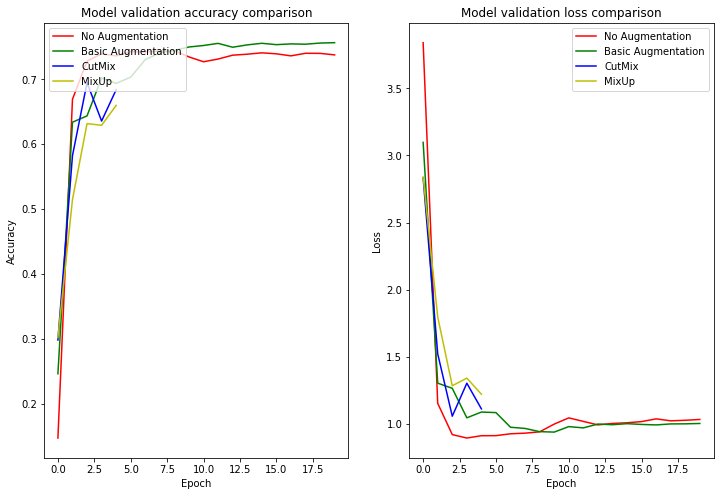

In [34]:
# 결과 시각화 (4가지 방법 비교)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history_dict_resnet50['val_accuracy'], 'r')
plt.plot(history_dict_aug_resnet50['val_accuracy'], 'g')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'b')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_dict_resnet50['val_loss'], 'r')
plt.plot(history_dict_aug_resnet50['val_loss'], 'g')
plt.plot(history_cutmix_resnet50.history['val_loss'], 'b')
plt.plot(history_mixup_resnet50.history['val_loss'], 'y')
plt.title('Model validation loss comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper right')
plt.show()

## 추가 학습

In [30]:
# 추가 학습시 모델 저장을 위한 체크포인트 경로 설정
checkpoint_path_cutmix = "cutmix_resnet50/cp.ckpt"
checkpoint_path_mixup = "mixup_resnet50/cp.ckpt"

In [31]:
# 저장된 모델 가중치 및 히스토리 불러오기
cutmix_resnet50.load_weights(checkpoint_path_cutmix)
history_dict_cutmix = json.load(open("cutmix_resnet50_history.json", 'r'))

mixup_resnet50.load_weights(checkpoint_path_mixup)
history_dict_mixup = json.load(open("mixup_resnet50_history.json", 'r'))

In [36]:
history_dict_cutmix = json.load(open("cutmix_resnet50_history.json", 'r'))
history_dict_mixup = json.load(open("mixup_resnet50_history.json", 'r'))

In [32]:
# 체크포인트 콜백 설정 (추가 학습을 위한)
cp_callback_cutmix = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_cutmix, 
    save_weights_only=True, 
    verbose=1)

cp_callback_mixup = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_mixup, 
    save_weights_only=True, 
    verbose=1)

In [33]:
# CutMix 적용 모델 추가 학습

additional_epochs = 10
batch_size = 16

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

additional_history_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=additional_epochs, 
    validation_data=ds_test,
    verbose=1, 
    use_multiprocessing=True,
    callbacks = [cp_callback_cutmix]
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
750/750 [==============================] - 167s 205ms/step - loss: 0.9130 - accuracy: 0.9019 - val_loss: 1.2332 - val_accuracy: 0.6771

Epoch 00001: saving model to cutmix_resnet50/cp.ckpt
Epoch 2/10
750/750 [==============================] - 154s 206ms/step - loss: 0.8980 - accuracy: 0.9008 - val_loss: 1.1617 - val_accuracy: 0.6980

Epoch 00002: saving model to cutmix_resnet50/cp.ckpt
Epoch 3/10
750/750 [==============================] - 154s 206ms/step - loss: 0.8986 - accuracy: 0.8988 - val_loss: 1.1667 - val_accuracy: 0.7016

Epoch 00003: saving model to cutmix_resnet50/cp.ckpt
Epoch 4/10
750/750 [==============================] - 154s 206ms/step - loss: 0.8831 - accuracy: 0.9034 - val_loss: 1.0963 - val_accuracy: 0.7165

Epoch 00004: saving model to cutmix_resnet50/cp.ckpt
Epoch 5/10
750/750 [==============================] - 154s 206ms/step - loss: 0.8805 - accuracy: 0.9053 - val_loss: 1.0861 - val_accuracy: 0.7182

Epoch 00005: saving model to cutmix_resnet50/cp.ckpt


In [34]:
# MixUp 적용 모델 추가 학습

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy']
)

additional_history_mixup = mixup_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=additional_epochs, 
    validation_data=ds_test,
    verbose=1, 
    use_multiprocessing=True,
    callbacks = [cp_callback_mixup]
)

Epoch 1/10
750/750 [==============================] - 163s 207ms/step - loss: 0.9553 - accuracy: 0.9188 - val_loss: 1.0997 - val_accuracy: 0.7143

Epoch 00001: saving model to mixup_resnet50/cp.ckpt
Epoch 2/10
750/750 [==============================] - 154s 206ms/step - loss: 0.9240 - accuracy: 0.9235 - val_loss: 1.1224 - val_accuracy: 0.7080

Epoch 00002: saving model to mixup_resnet50/cp.ckpt
Epoch 3/10
750/750 [==============================] - 154s 206ms/step - loss: 0.9155 - accuracy: 0.9227 - val_loss: 1.2503 - val_accuracy: 0.6863

Epoch 00003: saving model to mixup_resnet50/cp.ckpt
Epoch 4/10
750/750 [==============================] - 154s 206ms/step - loss: 0.9318 - accuracy: 0.9233 - val_loss: 1.1756 - val_accuracy: 0.6982

Epoch 00004: saving model to mixup_resnet50/cp.ckpt
Epoch 5/10
750/750 [==============================] - 154s 206ms/step - loss: 0.9337 - accuracy: 0.9262 - val_loss: 1.1531 - val_accuracy: 0.7043

Epoch 00005: saving model to mixup_resnet50/cp.ckpt
Epoch

In [37]:
# 추가 학습 히스토리를 기존 히스토리에 추가
for key in history_dict_cutmix.keys():
    history_dict_cutmix[key] += additional_history_cutmix.history[key]
for key in history_dict_mixup.keys():
    history_dict_mixup[key] += additional_history_mixup.history[key]

In [38]:
json.dump(history_dict_cutmix, open("cutmix_resnet50_history.json", 'w'))
json.dump(history_dict_mixup, open("mixup_resnet50_history.json", 'w'))

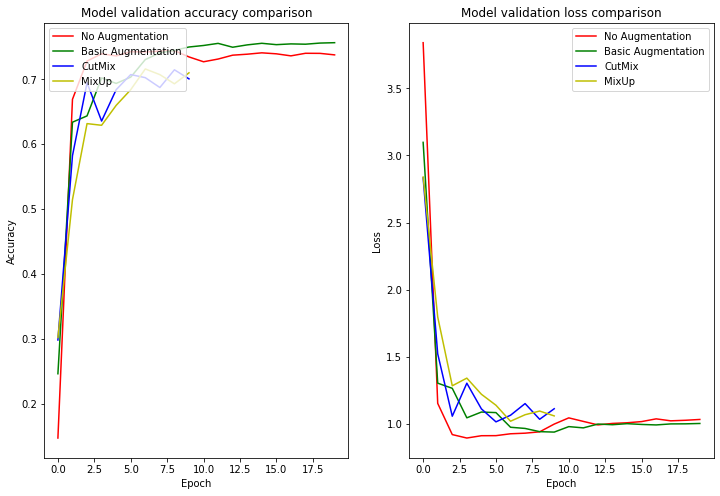

In [46]:
# 결과 시각화 (4가지 방법 비교) - 추가학습(10epoch)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history_dict_resnet50['val_accuracy'], 'r')
plt.plot(history_dict_aug_resnet50['val_accuracy'], 'g')
plt.plot( history_dict_cutmix['val_accuracy'], 'b')
plt.plot(history_dict_mixup['val_accuracy'], 'y')
plt.title('Model validation accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_dict_resnet50['val_loss'], 'r')
plt.plot(history_dict_aug_resnet50['val_loss'], 'g')
plt.plot( history_dict_cutmix['val_loss'], 'b')
plt.plot(history_dict_mixup['val_loss'], 'y')
plt.title('Model validation loss comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper right')
plt.show()

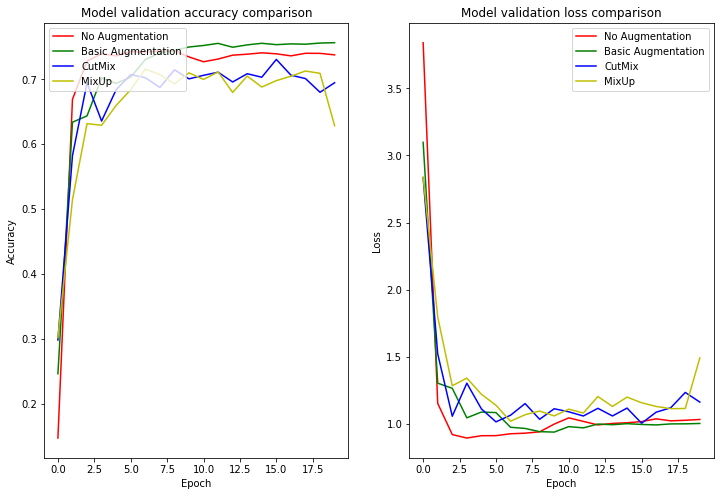

In [54]:
# 결과 시각화 (4가지 방법 비교) - 추가학습 2차(20 epoch)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history_dict_resnet50['val_accuracy'], 'r')
plt.plot(history_dict_aug_resnet50['val_accuracy'], 'g')
plt.plot( history_dict_cutmix['val_accuracy'], 'b')
plt.plot(history_dict_mixup['val_accuracy'], 'y')
plt.title('Model validation accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_dict_resnet50['val_loss'], 'r')
plt.plot(history_dict_aug_resnet50['val_loss'], 'g')
plt.plot( history_dict_cutmix['val_loss'], 'b')
plt.plot(history_dict_mixup['val_loss'], 'y')
plt.title('Model validation loss comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper right')
plt.show()

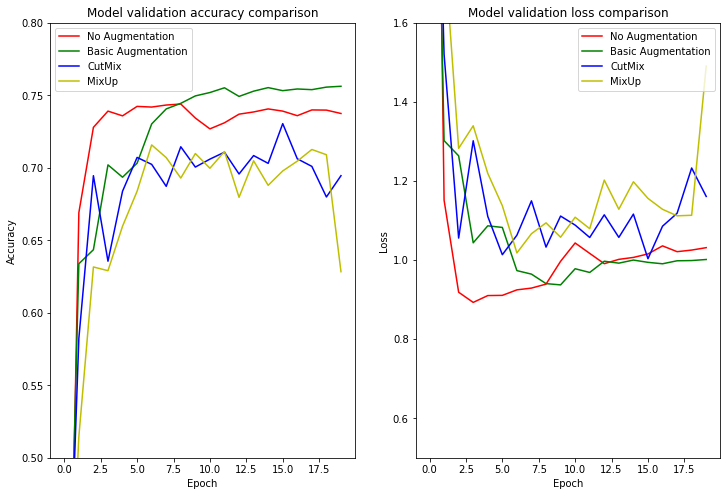

In [56]:
# 결과 시각화 (4가지 방법 비교) - 추가학습 2차 확대
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history_dict_resnet50['val_accuracy'], 'r')
plt.plot(history_dict_aug_resnet50['val_accuracy'], 'g')
plt.plot( history_dict_cutmix['val_accuracy'], 'b')
plt.plot(history_dict_mixup['val_accuracy'], 'y')
plt.title('Model validation accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.50, 0.80)
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_dict_resnet50['val_loss'], 'r')
plt.plot(history_dict_aug_resnet50['val_loss'], 'g')
plt.plot( history_dict_cutmix['val_loss'], 'b')
plt.plot(history_dict_mixup['val_loss'], 'y')
plt.title('Model validation loss comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.5, 1.6)
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper right')
plt.show()

결과를 보기에 충분한 에폭을 돌렸음에도 불구하고 Basic Augmentation 데이터셋으로 학습한 모델이 가장 좋은 성능을 나타내고 있습니다.
심지어 MixUp 을 적용하여 학습한 모델은 마지막 에폭에서 현저하게 기능이 상실되는 것으로 보아 과적합을 의심하게 하는 상황이며.. 이를 확인해보기 위해 10 epoch 씩 더 학습을 진행하기로 하였습니다.

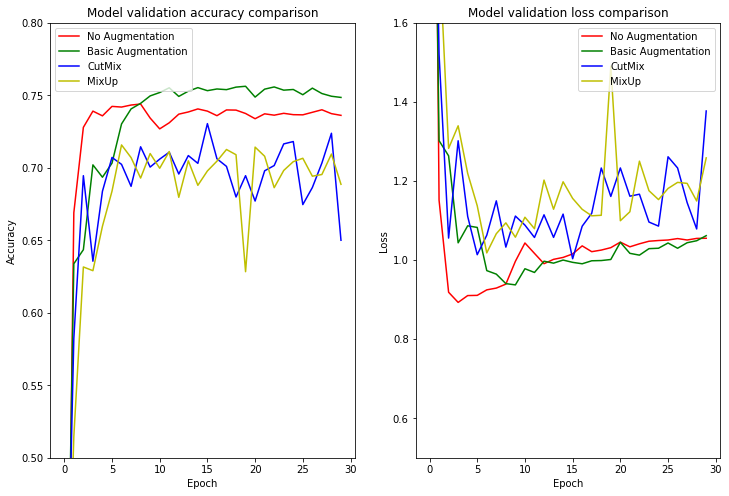

In [40]:
# 결과 시각화 (4가지 방법 비교) - 마지막 추가학습(30 epoch)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history_dict_resnet50['val_accuracy'], 'r')
plt.plot(history_dict_aug_resnet50['val_accuracy'], 'g')
plt.plot( history_dict_cutmix['val_accuracy'], 'b')
plt.plot(history_dict_mixup['val_accuracy'], 'y')
plt.title('Model validation accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.50, 0.80)
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_dict_resnet50['val_loss'], 'r')
plt.plot(history_dict_aug_resnet50['val_loss'], 'g')
plt.plot( history_dict_cutmix['val_loss'], 'b')
plt.plot(history_dict_mixup['val_loss'], 'y')
plt.title('Model validation loss comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0.5, 1.6)
plt.legend(['No Augmentation', 'Basic Augmentation', 'CutMix', 'MixUp'], loc='upper right')
plt.show()

평가문항	
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?	
상세기준 : CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?	
상세기준 : 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?	
상세기준 : 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

### 회고록
- 이 프로젝트는 ResNet50 모델을 불러와 다양한 Augmentation 기법을 적용해 보고 성능을 비교 분석하는 내용을 담고 있습니다.


- **느낀점** : 인공지능 학습 시에는 너무 큰 에폭으로 한번에 학습하는 것 보다는 중간 중간 저장하고 그 내용을 언제든 불러올 수 있도록 세션을 나누어서 학습 시키는 방법을 항상 고민해야겠습니다.  


- **배운점** : Pre-Train된 모델을 불러와 자유롭게 사용하는 방법에 대해서 알게 되었고, 다양한 Augmentation의 종류와 이를 데이터 셋에 적용하는 방법들에 대해 배웠습니다.  


- **아쉬운 점** : LMS 커널이 자꾸 죽어서 작은 에폭값으로 학습을 시키고 콜백 함수를 이용해 가중치를 불러오는 식으로 어렵게 학습을 진행시켜야 했습니다. 또한 결과에서 CutMix, MixUp 등이 더 효과적인 모델 학습 방법이라는 증거를 찾지 못했습니다.ㅠ  